In [22]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [23]:
from fullfmt import full_format_spec
from env import BattlerGameEnv
from go.game import game, ruby, milana, bot, formats

def new_env():
    return BattlerGameEnv(milana.CharacterMilana(), ruby.CharacterRuby(), bot.RandomBot(), formats.FullStateFormat(), full_format_spec())

In [24]:
env = new_env()

In [25]:
from tf_agents.environments import utils

utils.validate_py_environment(env, episodes=5)

In [26]:
from tf_agents.environments import tf_py_environment

train_py_env = new_env()
eval_py_env = new_env()

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(train_py_env)

In [27]:
import tensorflow as tf
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential, encoding_network
from fullfmt import full_format_preprocessing

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

combiner, spec = full_format_preprocessing()
q_net = encoding_network.EncodingNetwork(
    spec,
    preprocessing_combiner=combiner,
    fc_layer_params=(100, 50, num_actions)
)

# # Define a helper function to create Dense layers configured with the right
# # activation and kernel initializer.
# def dense_layer(num_units):
#   return tf.keras.layers.Dense(
#       num_units,
#       activation=tf.keras.activations.relu,
#       kernel_initializer=tf.keras.initializers.VarianceScaling(
#           scale=2.0, mode='fan_in', distribution='truncated_normal'))

# # QNetwork consists of a sequence of Dense layers followed by a dense layer
# # with `num_actions` units to generate one q_value per available action as
# # its output.
# dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
# q_values_layer = tf.keras.layers.Dense(
#     num_actions,
#     activation=None,
#     kernel_initializer=tf.keras.initializers.RandomUniform(
#         minval=-0.03, maxval=0.03),
#     bias_initializer=tf.keras.initializers.Constant(-0.2))
# q_net = sequential.Sequential(dense_layers + [q_values_layer])


In [28]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 10 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [29]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


In [30]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [31]:
from tf_agents.policies import random_tf_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [32]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics


In [33]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

1.0

In [34]:
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpq20kv1ib.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpq20kv1ib
[reverb/cc/platform/default/server.cc:71] Started replay server on port 34733


In [35]:
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy

py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())


(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(0., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': {'asopp': array([False]),
                  'char_defence_defence_black': array([-2]),
                  'char_defence_defence_blue': array([0]),
                  'char_defence_defence_brown': array([0]),
                  'char_defence_defence_cyan': array([1]),
                  'char_defence_defence_gray': array([0]),
                  'char_defence_defence_green': array([1]),
                  'char_defence_defence_orange': array([-1]),
                  'char_defence_defence_pink': array([0]),
                  'char_defence_defence_red': array([0]),
                  'char_defence_defence_violet': array([-1]),
                  'char_defence_defence_white': array([2]),
                  'char_defence_defence_yellow': array([1]),
                  'char_effect_euphoria_euphoricheal': array([False]),
                  'char_effect_euphoria

In [36]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset


<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': {'asopp': TensorSpec(shape=(64, 2, 1), dtype=tf.bool, name=None),
                 'char_defence_defence_black': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_blue': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_brown': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_cyan': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_gray': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_green': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_orange': TensorSpec(shape=(64, 2, 1), dtype=tf.int64, name=None),
                 'char_defence_defence_pink': TensorSpec(shape=(64, 2, 1), dtype

In [37]:
iterator = iter(dataset)
print(iterator)

In [38]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (4903) so Table uniform_table is accessed directly without gRPC.


step = 200: loss = 925.9110107421875
step = 400: loss = 2138.1396484375
step = 600: loss = 95.87299346923828
step = 800: loss = 1805.6884765625
step = 1000: loss = 1052.9912109375
step = 1000: Average Return = 255.0
step = 1200: loss = 1594.802001953125
step = 1400: loss = 1140.303955078125
step = 1600: loss = 640.1133422851562
step = 1800: loss = 450.6563415527344
step = 2000: loss = 250.914306640625
step = 2000: Average Return = 255.0
step = 2200: loss = 576.0319213867188
step = 2400: loss = 1788.112548828125
step = 2600: loss = 436.5327453613281
step = 2800: loss = 255.435302734375
step = 3000: loss = 389.52239990234375
step = 3000: Average Return = 281.20001220703125
step = 3200: loss = 776.5948486328125
step = 3400: loss = 420.37799072265625
step = 3600: loss = 332.51043701171875
step = 3800: loss = 334.8929748535156
step = 4000: loss = 128.82736206054688
step = 4000: Average Return = 237.10000610351562
step = 4200: loss = 377.6467590332031
step = 4400: loss = 119.40070343017578
s

Text(0.5, 0, 'Iterations')

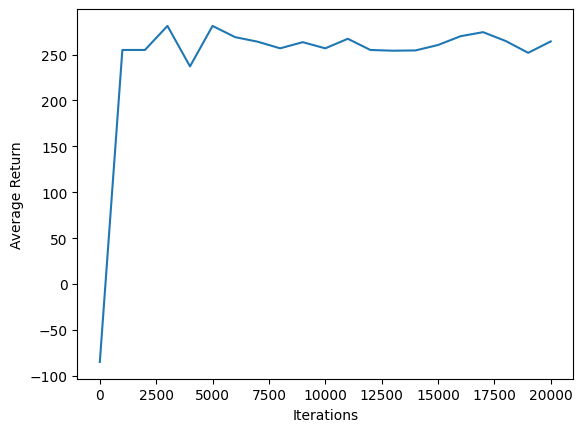

In [42]:
import matplotlib.pyplot as plt

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')


In [40]:
from tf_agents.policies import policy_saver

policy_dir = 'policy'
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [41]:
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: policy/assets


/home/andrey/Documents/coding/battler/.venv/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: policy/assets
